[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/3.1.detector_train.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

In [72]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip -d ./data/RTSD
    !rm rtsd-dataset.zip
    !cp -r data/RTSD/rtsd-frames/rtsd-frames/ data/RTSD/
    !rm -r data/RTSD/rtsd-frames/rtsd-frames/
    !pip install fiftyone

In [181]:
import json
import os
import numpy as np 

from PIL import Image
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from IPython.display import clear_output

from pycocotools.coco import COCO
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## Обучение детектора
детектор распознает 1 класс (дорожный знак) - далее он будет передаваться классификатору

### Пути и параметры

In [86]:
dataset_path = 'data/RTSD'
checkpoints_path = 'checkpoints' if colab == False else '../content/drive/MyDrive/TSR/checkpoints'

batch_size = 8
num_classes = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0) if device.type == 'cuda' else device.type)

NVIDIA GeForce RTX 3090


### Загрузчик данных

In [87]:
class RTSD_dataset_one_class(Dataset):
    '''
    Faster R-CNN при обучении ожидает на вход:
    - список тензоров размерностью [C, H, W] для каждого изображения со значениями в диапазоне 0-1
    - таргет: список словарей с ключами:
                - boxes (FloatTensor[N, 4]): ограничивающие рамки ground-truth в формате [x1, y1, x2, y2], с 0 <= x1 < x2 <= W и 0 <= y1 < y2 <= H.
                - labels (Int64Tensor[N]): метки классов для каждой ограничивающей рамки ground-truth (включая background)
    '''
    
    def __init__(self, root, annotation, transforms=None):
        super().__init__()
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Файл coco
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: получение ID аннотаций из coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: загрузка аннатаций для изображения
        coco_annotation = coco.loadAnns(ann_ids)
        # Путь к изображению
        path = coco.loadImgs(img_id)[0]['file_name']
        
        # Загрузка изображения
        #img = cv2.imread(os.path.join(self.root, path))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # загрузка с помощью PIL оказалась быстрее, чем с помощью OpenCV
        img = Image.open(os.path.join(self.root, path))
        img = np.array(img)

        # Количество объектов на изображении
        num_objs = len(coco_annotation)
        
        # Bounding boxes для объектов
        # В coco формате bbox = [xmin, ymin, width, height]
        # Для pytorch bbox должны быть в формате [xmin, ymin, xmax, ymax]
        boxes = []
        #labels = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            #labels.append(coco_annotation[i]['category_id'])
        
        # Метки классов
        #labels = torch.as_tensor(labels, dtype=torch.int64)
        # Используется только 1 класс - знак
        labels = torch.ones((num_objs,), dtype=torch.int64)  
        
        if self.transforms is not None:
            img, boxes = self.transform(img, boxes, labels)

        img = img/255   
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Аннотация в формате словаря
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels

        return img, my_annotation

    def __len__(self):
        return len(self.ids)
    
    def transform(self, img, boxes, labels):
        
        num_boxes = 0
        while num_boxes == 0:
            
            transformed = self.transforms(image=img, bboxes=boxes, labels=labels)
            img_transformed = transformed['image']
            boxes_transformed = transformed['bboxes']
            num_boxes = len(boxes_transformed)
        
        return img_transformed, boxes_transformed

In [88]:
# При параметре train=True выполняется аугментация и преобразование в тензор
# При параметре train=False выполняется только преобразование в тензор
def get_transform(train=False):
    if train==True:
        return A.Compose([A.HorizontalFlip(p=0.5),
                          A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
                          A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.3, alpha_coef=0.1, p=0.05), #Туман
                          A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=0.05),
                          A.Rotate(limit=10, p=0.5),
                          #A.RandomShadow(num_shadows_lower=1, num_shadows_upper=1, shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=1),
                          #A.RandomSnow(brightness_coeff=1.5, snow_point_lower=0.3, snow_point_upper=0.5, p=1),
                          #A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=1),
                          # ToTensorV2 конвертирует изображение в pytorch тензор без деления на 255
                          ToTensorV2(p=1.0)
                          ],
                          bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
        
    else:
        return A.Compose([ToTensorV2(p=1.0)],
                         bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [89]:
train_dataset = RTSD_dataset_one_class(dataset_path,
                                       os.path.join(dataset_path, 'train_anno.json'),
                                       transforms = get_transform(train=True)
                                       )

val_dataset = RTSD_dataset_one_class(dataset_path,
                                     os.path.join(dataset_path, 'val_anno.json'),
                                     transforms = get_transform(train=False)
                                     )

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [90]:
def plot_img_bbox(img, target):
    # функция отрисовки изображения и ограничивающих рамок (x-min y-min width height)
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # отрисовка ограничивающих рамок на изображении
        a.add_patch(rect)
    plt.show()

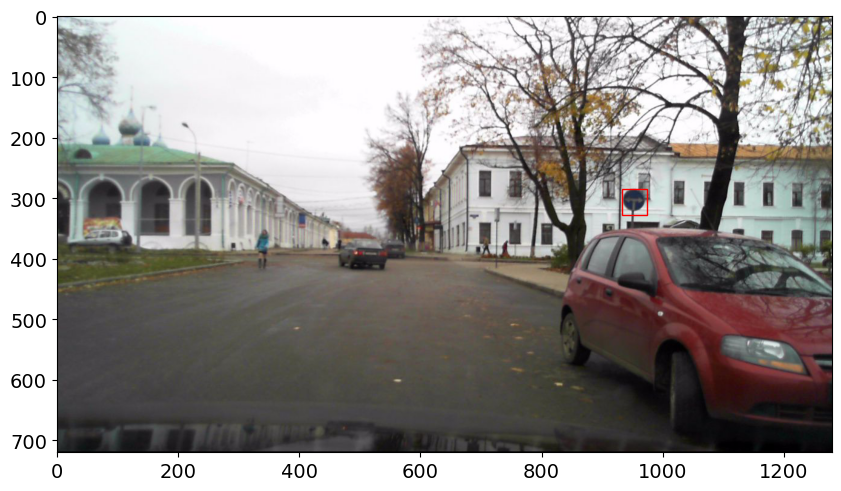

In [80]:
%matplotlib inline
img, target = train_dataset.__getitem__(4000)
img = (img.permute(1, 2, 0).detach().numpy()*255).astype(np.uint8)
plot_img_bbox(img, target)

### Формирование батча

In [91]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [92]:
train_data_loader = DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               collate_fn=collate_fn
                               )

val_data_loader = DataLoader(val_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             collate_fn=collate_fn
                             )

### Параметры модели и обучения

In [93]:
#model_name = 'mobilenet_v3_320_augmented'
#model_name = 'mobilenet_v3_augmented'
#model_name = 'resnet50_augmented'
model_name = 'resnet50_v2_augmented'

# эпоха для загрузки параметров, обучение начинается со следующей
last_epoch = None
n_epochs = 10       # полное количество эпох для обучения

### Инициализация модели, задание оптимизатора и функции потерь

In [141]:
def create_model(model_name, num_classes):
    # load model pre-trained on COCO
    if ('resnet50_v2' in model_name) or ('resnet50v2' in model_name):
        model =torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT')
        print("Загружена модель ResNet50_v2")
    elif 'resnet50' in model_name:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
        print("Загружена модель ResNet50")
    elif ('mobilenet' in model_name) and ('320' in model_name):
        model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights='FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT')
        print("Загружена модель MobileNet_V3_Large_320")
    elif 'mobilenet' in model_name:
        model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights='FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT')
        print("Загружена модель MobileNet_V3_Large")  
    else:
        print("Проверить название модели")
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [182]:
model = create_model(model_name=model_name, num_classes=num_classes).to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# learning rate scheduler уменьшает learning rate в 10 раз каждые 3 эпохи
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# Загрузка весов модели, состояния оптимизатора и шедулера
if last_epoch is not None:
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_detector_{model_name}_b{batch_size}_{last_epoch}.pth'), map_location=device)
    print(f'Для модели {model_name} с размером батча {batch_size} загружены веса {last_epoch} эпохи')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

Загружена модель MobileNet_V3_Large_320


### Трейн луп

In [183]:
def train(train_dataloader, epoch, plot=False, train_loss_history=None, valid_loss_history=None): 
    
    model.train()

    len_dataloader = len(train_dataloader)
    running_loss = 0
    current_loss_history = []
    
    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = batch[0], batch[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        current_loss_history.append(loss.item())  
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if plot == True:
        
            # Рисуем график
            if (step+1)%10==0:
                
                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
                
                clear_output(True)           
                ax[0].plot(current_loss_history, label='train loss')
                ax[0].set_xlabel('Batch')
                ax[0].set_title(f'Train loss current epoch')
                if train_loss_history is not None:
                    ax[1].plot(train_loss_history, label='Train')
                if valid_loss_history is not None:
                    ax[1].plot(valid_loss_history, label='Valid')
                if (train_loss_history is not None) or (valid_loss_history is not None):
                    ax[1].set_xlabel('Epoch')
                    ax[1].set_title('General loss history')
                    ax[1].legend()
                plt.show()

        else:
            if step%50 == 0:
                print(f"\tEpoch: {epoch:02}. Iteration: {step}/{len_dataloader}. Train loss: {loss:.3f}", end='\r')
    
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def evaluate(val_dataloader, epoch, plot=False):
    len_dataloader = len(val_dataloader)
    running_loss = 0
    for step, data in enumerate(val_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        if plot == False:
            if step % 50 == 0:
                print(f"\tEpoch: {epoch:02}. Iteration: {step}/{len_dataloader}. Valid loss: {loss:.3f}", end='\r')
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [184]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [185]:
def train_eval_loop(model, model_name, train_dataloader, val_dataloader, last_epoch=None, n_epochs=10, plot=False, save_all_epochs=False):

    # Загрузка словарей с лоссами
    if last_epoch is not None:
        start_epoch = last_epoch +1
        train_loss_history = checkpoint['losses_train']
        valid_loss_history = checkpoint['losses_val']
        
    else:
        start_epoch = 0
        train_loss_history = []
        valid_loss_history = []

    for epoch in range(start_epoch, n_epochs):
        
        try:
        
            start_time = time.time()
            
            train_loss = train(train_dataloader, epoch, plot, train_loss_history, valid_loss_history)
            valid_loss = evaluate(val_dataloader, epoch, plot)

            train_loss_history.append(train_loss)
            valid_loss_history.append(valid_loss)

            lr_scheduler.step()

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                'losses_train': train_loss_history,
                'losses_val': valid_loss_history
                }, os.path.join(checkpoints_path, f'chkpt_detector_{model_name}_b{batch_size}_{epoch}.pth'))
            
            torch.save(model, os.path.join(checkpoints_path, f'model_detector_{model_name}_b{batch_size}_{epoch}.pth'))

            # дополнительное сохранение словарей лоссов в json
            with open(os.path.join(checkpoints_path, f'losses_detector_{model_name}_b{batch_size}.json'), 'w') as fp:
                json.dump({'losses_train':train_loss_history,
                        'losses_val':valid_loss_history}, fp)

            end_time = time.time()
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            if plot == False:
                print(f'Epoch: {epoch:02} | Time: {epoch_mins}m {epoch_secs}s | Train loss: {train_loss:.3f} | Val loss: {valid_loss:.3f}')

        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем' + ' '*20)
            break

    return None

In [186]:
train_eval_loop(model, model_name, train_data_loader, val_data_loader, last_epoch=None, n_epochs=10, plot=True)

Epoch: 00 | Time: 1m 41s | Train loss: 0.005 | Val loss: 0.007
Epoch: 01 | Time: 1m 40s | Train loss: 0.005 | Val loss: 0.010
Досрочно остановлено пользователем                    
